# Анализ работы сети фитнес-центров

# Содержание

- Краткий общий вывод
- Описание данных
- Шаг 1. Откроем файлы с данными и изучим общую информацию
- Шаг 2. Подготовим данные
- Шаг 3. Проведём исследовательский анализ данных (EDA)
- Шаг 4. Построим модель прогнозирования оттока клиентов
- Шаг 5. Сделаем кластеризацию клиентов
- Шаг 6. Сформулируем выводы и сделаем базовые рекомендации по работе с клиентами

# Краткий общий вывод

После проведения анализа и подготовки данных нам удалось разработать алгоритм для предсказывания оттока клиентов на уровне следующего месяца с полнотой 86% (доля оттока, которую удаётся обнаружить).

Выявлены основные признаки, влияющие на отток (обратно пропорционально):

- жизненный путь клиента lifetime
- средняя частоста посещений клуба за последний месяц avg_class_frequency_current_month
- возраст age
- срок действующего абонемента contract_period
- количество месяцев до истечения абонемента month_to_end_contract


В целом, практически все распределения признаков упорядочены по степени их склонности к оттоку - чем меньше значение параметра, тем вероятнее отток.

Следовательно, борьба с оттоком должна быть направлена на максимизацию всех возможных параметров.

Нужно предлагать клиентам бонусы за регулярность и частоту - возможно, сверх-скидки на продолжительные абонементы / занятие с тренером, как награда за регулярное посещение. Нужно активно предлагать данным клиентам групповые программы, возможно, предлагать бесплатное посещение коммерческих классов.

# Шаг 1. Откроем файлы с данными и изучим общую информацию

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

from plotly import graph_objects as go

In [2]:
data = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
df_list = [data]
for df in df_list:
    print('Первые 5 строк')
    print('-'*50)
    display(df.head())
    print('-'*50)
    print('Размер датафрейма: (строк:столбцов) {}'.format(df.shape))
    print('-'*50)
    print('Типы данных и общая информация')
    print(df.info())
    print('-'*50)
    print('Наличие дубликатов: {}'.format(df.duplicated().sum()))
    print('-'*50)
    print('Наличие пропусков')
    print('-'*50)
    print(df.isna().sum())
    print('Стат данные')
    print('-'*50)
    display(df.describe())

Первые 5 строк
--------------------------------------------------


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


--------------------------------------------------
Размер датафрейма: (строк:столбцов) (4000, 14)
--------------------------------------------------
Типы данных и общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Mont

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


- Данные на первый взгляд хорошие, пропусков и дубликатов нет.
    
    
- Пол представлен примерно поровну.
- Большинство клиентов (85%) проживают или работают около фитнес-центра.
- Почти половина клиентов являются сотрудниками компаний-партнёров клуба, т.е. оформили абонемент со скидкой.
- 31% клиентов попали в зал по акции "приведи друга".
- Телефон указан в 90% анкет.
- Больше половины клиентов имеют действующий контракт на 1 месяц.
- 41% клиентов посещают групповые занятия.
- Средний возраст клиента - 29 лет.
- Средняя суммарная выручка от доп. услуг фитнес-центра - 147 ед.
- Средний срок окончания действия текущего абонемента - 4.3 мес. Стандартное отклонение в 4 мес свидетельствует о скошенности распределения. Больше половины клиентов в течение 1 месяца останутся без активного абонемента.
- Среднее время жизни клиента - 3.7 мес.
- Средняя частота посещений за весь период - 1.88 в неделю.
- Средняя частота посещений за текущий месяц - 1.77 в неделю.
- Отток в текущем месяце - 26.5%  

# Шаг 2. Подготовим данные

In [4]:
data.columns = data.columns.str.lower()

Поменяю для удобства типы данных:

In [5]:
data[['gender','near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']] = \
            data[['gender','near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']].astype('bool')

In [6]:
data['month_to_end_contract'] = data['month_to_end_contract'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   bool   
 1   near_location                      4000 non-null   bool   
 2   partner                            4000 non-null   bool   
 3   promo_friends                      4000 non-null   bool   
 4   phone                              4000 non-null   bool   
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   bool   
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int32  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

# Шаг 3. Проведём исследовательский анализ данных (EDA)

## Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуемся методом groupby()):

In [7]:
display(data.groupby('churn').agg('mean').T)

churn,False,True
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


- Пол распределился равномерно.
- Не попавшие в отток клиенты чуть чаще живут/работают поблизости к фитнес-центру (87% против 77%).
- Только треть (36%) клиентов, попавших в отток, работают в компаниях-партнёрах клуба. Доля таких сотрудников среди оставшихся - 53%.
- 18% клиентов, попавших в отток, пришли в центр по акции "приведи друга". Доля таких клиентов среди оставшихся - 35%.
- Телефон указан одинаково часто (90% анкет).
- Клиенты, попавшие в отток, заключали последний контракт в среднем на 1.7 мес. Оставшиеся - на 5.7 мес.
- Клиенты, попавшие в отток, реже посещали групповые занятия, чем оставшиеся (27% против 46%).
- Средний возраст клиентов, попавших в отток, - 27 лет. Оставшихся - 30 лет.
- Средняя сумма дополнительных трат у попавших в отток клиентов ниже, чем у оставшихся (115 против 158).
- В среднем у попавших в отток клиентов контракт истекает в длижайшие 1.7 мес. У оставшихся в запасе в среднем 5.3 мес.
- Средний срок жизни (время с момента первого обращения) попавших в отток клиентов - 1 мес., оставшихся - 4.7 мес.
- Средняя частота посещений за весь период у клиентов, попавших в отток, ниже, чем у оставшихся (1.47 против 2 раз в неделю).
- Средняя частота посещений за последний месяц у попавших в отток клиентов в 2 раза ниже, чем у оставшихся - 1 против 2 раз в неделю.

## Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток):

In [8]:
# Функция для построения графика распредления и ящика с усами для непрерывных признаков.
# Принимает на вход датафрейм data, название признака feature и заголовок для графиков title.
def cntns_feature_plots(data, feature, title):
    fig, ax = plt.subplots(figsize = (12, 4))

    try:
        sns.distplot(data[data['churn']==1][feature], label = 'отток', color = 'orange', ax = plt.subplot(1, 2, 1))
        sns.distplot(data[data['churn']==0][feature], color = 'green', ax = plt.subplot(1, 2, 1)) 
    except RuntimeError as re:
        if str(re).startswith("Selected KDE bandwidth is 0. Cannot estiamte density."):
            sns.distplot(data[data['churn']==1][feature], label = 'отток', color = 'orange', kde_kws={'bw': 0.1}, ax = plt.subplot(1, 2, 1))
            sns.distplot(data[data['churn']==0][feature], color = 'green', kde_kws={'bw': 0.1}, ax = plt.subplot(1, 2, 1))
        else:
            raise re
    plt.xlabel('')
    plt.ylabel('')
    plt.legend()

    sns.boxplot(y = feature, x = 'churn', data = data, ax = plt.subplot(1, 2, 2)) 
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(np.arange(2), ('Активные клиенты', 'Отток'))

    fig.suptitle(title + ' (' + feature + ')')
    plt.show()

In [9]:
# Функция для построения гистограммы и ящика с усами для дискретных признаков.
# Принимает на вход датафрейм data, название признака feature и заголовок для графиков title.
def dscrt_feature_plots(data, feature, title):  
    fig, ax = plt.subplots(figsize = (12, 4))

    sns.countplot(x = feature, hue = 'churn', data = data, ax = plt.subplot(1, 2, 1))
    plt.ylabel('')
    plt.xlabel('')
    plt.legend()

    gr = data.groupby([feature, 'churn']).agg(count=('age', 'count')).reset_index()
    sns.boxplot(x = feature, y = 'count', data=gr, ax = plt.subplot(1, 2, 2)) 
    plt.xlabel('')
    plt.ylabel('')

    fig.suptitle(title + ' (' + feature + ')')
    plt.show()

In [10]:
# Составим списки с названиями числовых признаков и их заголовками на русском языке:
f_cnt_list = ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
              'avg_class_frequency_total', 'avg_class_frequency_current_month']
t_cnt_list = ['Возраст', 'Сумма дополнительных трат', 'Срок окончания действующего абонемента, мес', 
              'Время с момента первого обращения, мес', 'Средняя частота посещений в неделю за весь период', 
              'Средняя частота посещений в неделю за последний месяц']

# Составим списки с названиями категориальных признаков и их заголовками на русском языке:
f_dscrt_list = ['gender', 'near_location', 'partner', 'promo_friends', 
                'phone', 'contract_period', 'group_visits']
t_dscrt_list = ['Пол', 'Проживание/работа около клуба', 'Сотрудники компании-партнёра', 
                'Клиенты, пришедшие по акции "Приведи друга"', 'Телефон', 'Длительность текущего абонемента, мес', 
                'Посещение групповых программ']

# Соберём для удобства в DataFrame:
cnt_features = pd.DataFrame({'feature': f_cnt_list, 'title': t_cnt_list})
dscrt_features = pd.DataFrame({'feature': f_dscrt_list, 'title': t_dscrt_list})

Рассмотрим распределения числовых признаков:

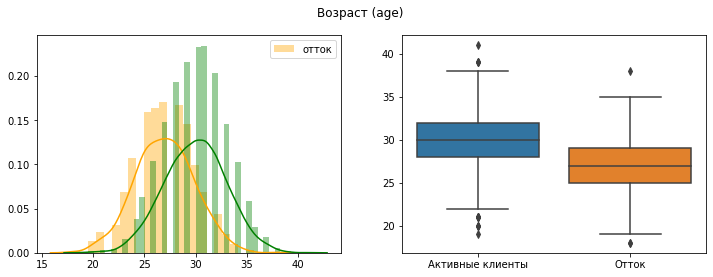

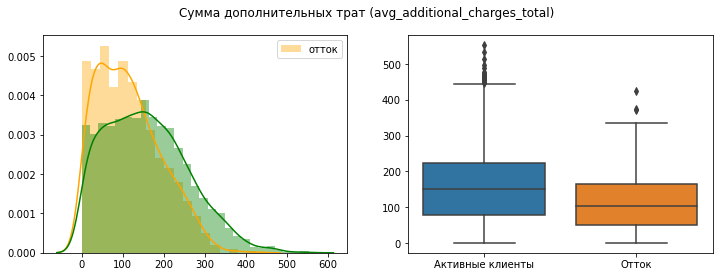

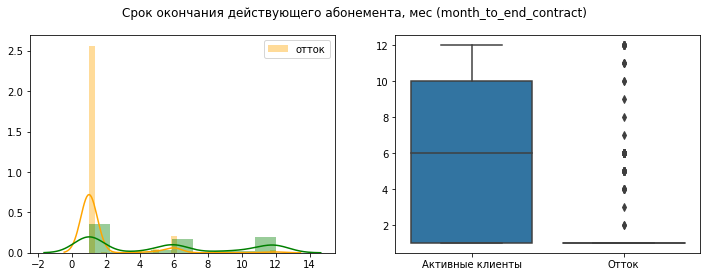

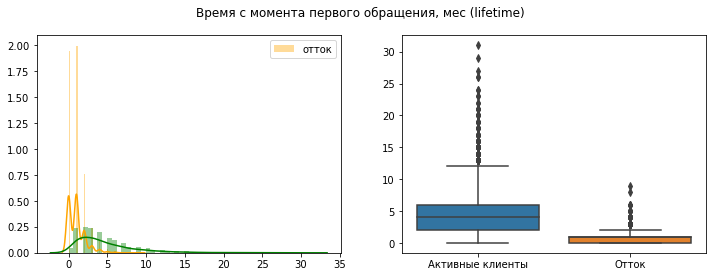

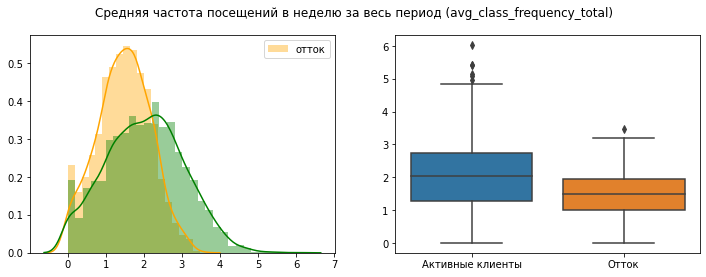

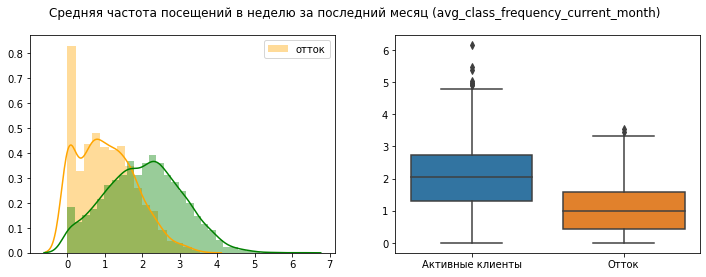

In [11]:
for index, row in cnt_features.iterrows():
    cntns_feature_plots(data, row[0], row[1])


- Возраст распределён равномерно как среди оставшихся, так и среди попавших в отток клиентов. При этом активные клиенты в среднем старше ушедших.
- Распределение дополнительных трат скошено влево. Активные клиенты тратят в среднем больше тех, кто попал в отток.
- Большинство клиентов, попавших в отток, имели на руках истекающий в текущем месяце абонемент.
- Попадающие в отток клиенты чаще всего уходят после первого месяца.
- Средняя частота посещений в неделю за весь период выше у активных клиентов.
- Последний перед оттоком месяц большинство ушедших клиентов не посещали клуб.

**Рассмотрим распределения категориальных признаков:**

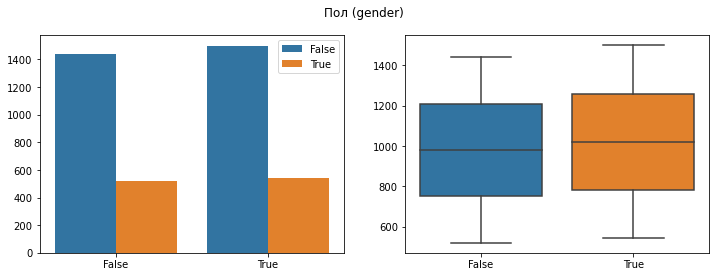

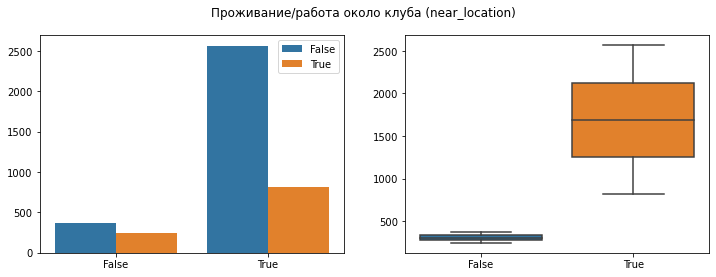

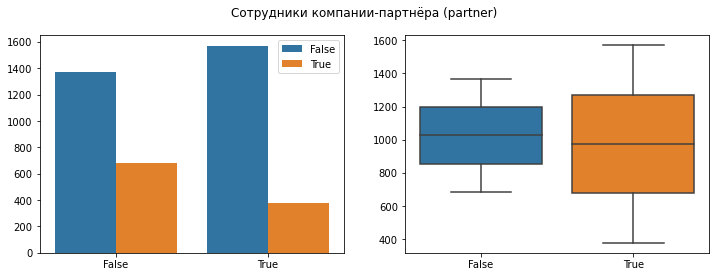

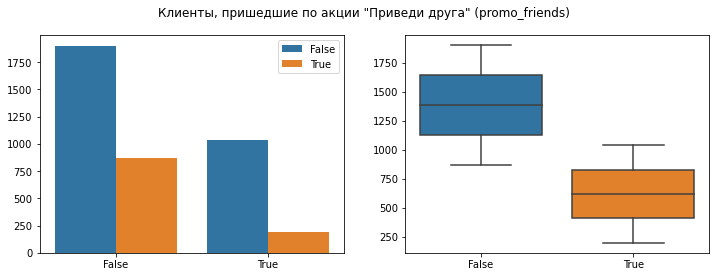

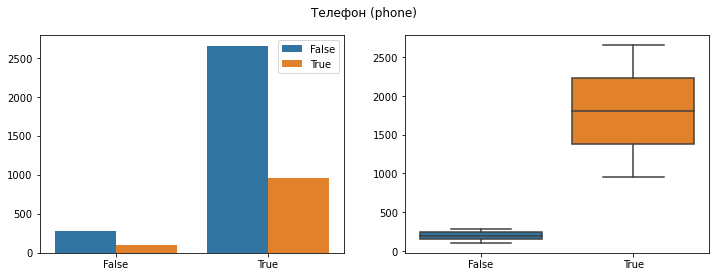

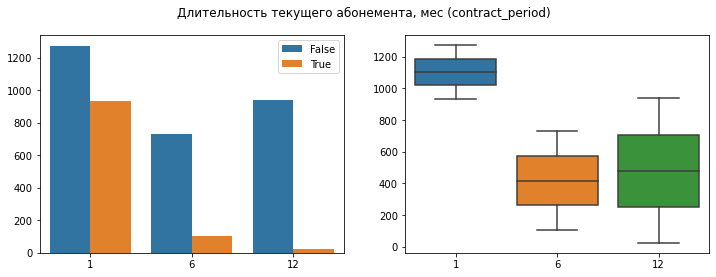

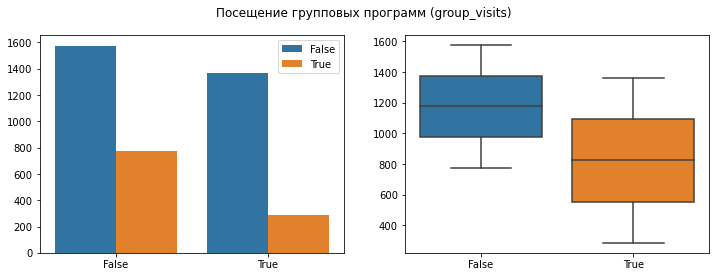

In [12]:
for index, row in dscrt_features.iterrows():
    dscrt_feature_plots(data, row[0], row[1])

- Пол распределён равномерно, как внутри оттока, так и по всей базе в целом.
- Среди людей, живущих в отдалении от фитнес-центра, доля попавших в отток значительно выше, чем среди тех, кто живёт поблизости.
- Почти половина клиентов, не работающих в компаниях-партнёрах (т.е. не имеющих постоянных скидок на абонемент), в итоге попали в отток. Доля ушедших в отток сотрудников компаний-партнёров значительно меньше.
- Клиенты, пришедшие по акции "Приведи друга" реже остальных попадают в отток. Вероятно, ходить в зал вместе с товарищем веселее.
- Судя по гистограммам, наличие телефона в анкете никак не влияет на долю оттока.
- Больше всего клиентов, попавших в отток, среди тех, кто имел на руках абонемент на месяц. Вероятно, сначала люди покупают абонемент на самый короткий срок, чтобы оценить свои силы и только в случае успеха тратятся на длительные карты. Реже остальных попадают в отток клиенты с 12-месячными абонементами.
- Люди, посещающие групповые программы, реже попадают в отток. Возможно, расписание с фиксированным временем помогает клиентам держать ритм.

# Матрица корреляций.

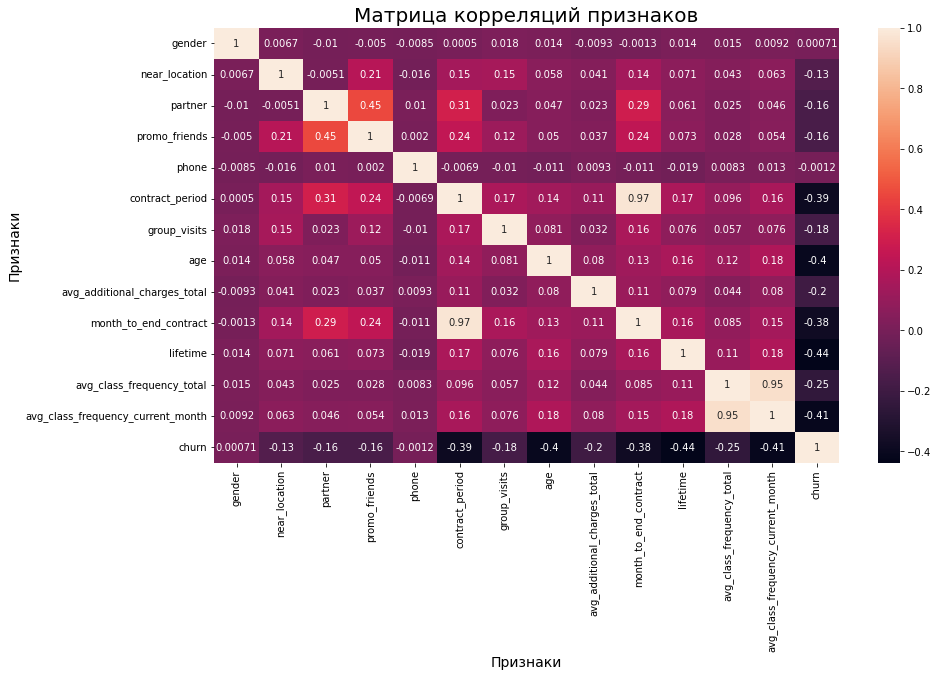

In [13]:
matr = data.corr()
plt.figure(figsize=(14,8))
sns.heatmap(matr, annot = True, square=False)
plt.title('Матрица корреляций признаков', fontsize = 20)
plt.xlabel('Признаки', fontsize = 14) 
plt.ylabel('Признаки', fontsize = 14) 
plt.show()

- Здесь общая картина похожа на, ту которая в пункте 2.2. Но есть и отличия. По карте видно, что 'partner', 'group_visits', 'promo_friends' - оказывают всетаки очень слабое влияние, а 'age' наоборот более сильное

- На карте между 'churn' и признаками видна обратная корреляция - это говорит о том, что чем сильнее признак, тем слабее отток.

- По цифрам корреляции можно сказать, что все признаки слабо коррелируют, вопрос в том насколько слабо:

- 1.(-)'gender' и 'phone' - никакого влияния признаков на 'churn'. Корреляция почти 0  

- 2.(+-)'near_location', 'partner', 'promo_friends', 'group_visits', 'avg_additional_charges_total', 'avg_class_frequency_total'. Корреляция в диапазоне -(0,1-0,25) - очень слабая.  

- 3. (+) 'contract_period', 'age', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_current_month'. Корреляция в диапазоне -(0,38-0,44) - просто слабая.

- Также надо отметить очень сильную (выше 0,95) корреляцию пар признаков, которую надо будет учесть в моделях линейной регрессии:
- а) 'contract_period' и 'month_to_end_contract'- чем больше период абонемента, тем скорее всего больше месяцев осталось;
- б) 'avg_class_frequency_current_month' и 'avg_class_frequency_total' - здесь очень логично, те кто давно уже ходит с постоянным графиком, тот и за последний месяц ходил скорее всего с таким же графиком.

# Шаг 3. Построим модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

Разделим наши данные на признаки (матрица X) и целевую переменную (y):

In [14]:
X = data.drop('churn', axis=1)
y = data['churn'] 

Разобьём данные на обучающую и валидационную выборку функцией train_test_split():

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) 
display(X_train_st[:5])

#применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

array([[-1.01511421,  0.4175068 ,  1.03175391,  1.4800097 ,  0.31628211,
         1.60502986, -0.84769226,  0.57944798,  0.37161711,  1.59173796,
         1.12734972,  1.75580418,  1.61822807],
       [-1.01511421,  0.4175068 , -0.96922337, -0.67567125,  0.31628211,
        -0.81299073, -0.84769226,  0.27046055, -1.09697378, -0.79568246,
         5.88138322, -0.2239674 , -0.01340886],
       [ 0.98511083,  0.4175068 ,  1.03175391, -0.67567125,  0.31628211,
         1.60502986, -0.84769226, -0.65650171, -1.18374157,  1.83048   ,
         0.3350108 , -0.84308456, -0.80541199],
       [-1.01511421,  0.4175068 ,  1.03175391,  1.4800097 ,  0.31628211,
         0.28610954, -0.84769226, -0.96548914, -0.95158829,  0.39802775,
         1.39146269,  0.66771379,  0.64605224],
       [-1.01511421,  0.4175068 , -0.96922337, -0.67567125, -3.16173427,
        -0.81299073, -0.84769226, -0.03852687,  0.97190435, -0.79568246,
         0.07089783, -0.19587934, -0.16038147]])

- Обучим модель на train-выборке двумя способами:
- логистической регрессией,
- случайным лесом.

Напишем функцию, которая получает на вход название модели и саму модель, а выводит метрики. Затем применим её к обеим моделям прогнозирования:

In [ ]:
# def show_metrics(name, mdl):
    mdl.fit(X_train_st, y_train)
    y_pred = mdl.predict(X_test_st)
    print("Модель прогнозирования -", name)
    
    acc = accuracy_score(y_test, y_pred)
    print("Доля правильных ответов: Accuracy =",acc.round(3))
    precision = precision_score(y_test, y_pred).round(3)
    print("Точность: precision =", precision)
    recall = recall_score(y_test, y_pred).round(3)
    print("Полнота: recall =", recall, '\n')

model = LogisticRegression(random_state=0)
show_metrics('"Логистическая регрессия"', model)

model = RandomForestClassifier(n_estimators = 100, random_state=0)
show_metrics('"Случайный лес"', model)

**Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели:**

- По параметру Accuracy "Логистическая регрессия" немного выигрывает у "Случайный лес" (0,922 против 0,915), по precision тоже "Логистическая регрессия" получше (0,854 проитив 0,839) и также немного лучше по recall (0,828 против 0,813)


- По всем параметрам "Логистическая регрессия" дает результат немного лучше чем "Случайный лес"


- Также надо отметить у обоих моделей очень высокий показатель Accuracy (больше 0,91), а также высокие показатели precision и recall (в диапазоне 0,813 - 0,854)

В общем и целом обе модели показали вполне отличные результаты, "Логистическая регрессия" - немного лучше.

# Шаг 4. Сделаем кластеризацию клиентов

Стандартизируем данные:

In [17]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_sc[:3]

array([[ 0.97970588,  0.42788074,  1.02686062,  1.49716101, -3.05985201,
         0.28989014,  1.19403206, -0.0565538 , -1.37753121,  0.16160501,
        -0.19332863, -1.91191971, -1.67847198],
       [-1.0207145 ,  0.42788074, -0.973842  , -0.66793083,  0.32681319,
         1.60882159,  1.19403206,  0.55732732, -0.35021325,  1.83194105,
         0.87368001,  0.04517569,  0.1360137 ],
       [-1.0207145 ,  0.42788074,  1.02686062, -0.66793083,  0.32681319,
        -0.8092194 , -0.83749845, -0.36349436, -0.1815923 , -0.79287273,
        -0.46008079, -0.02049263, -0.02901851]])

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму:

In [18]:
linked = linkage(X_sc, method = 'ward')
linked

array([[9.70000000e+01, 3.22200000e+03, 1.00990653e-01, 2.00000000e+00],
       [2.61000000e+02, 3.17900000e+03, 1.22634574e-01, 2.00000000e+00],
       [8.90000000e+02, 1.75000000e+03, 1.28123291e-01, 2.00000000e+00],
       ...,
       [7.98700000e+03, 7.99500000e+03, 8.38725499e+01, 2.65600000e+03],
       [7.98800000e+03, 7.99600000e+03, 8.89563592e+01, 3.03400000e+03],
       [7.99200000e+03, 7.99700000e+03, 1.04627601e+02, 4.00000000e+03]])

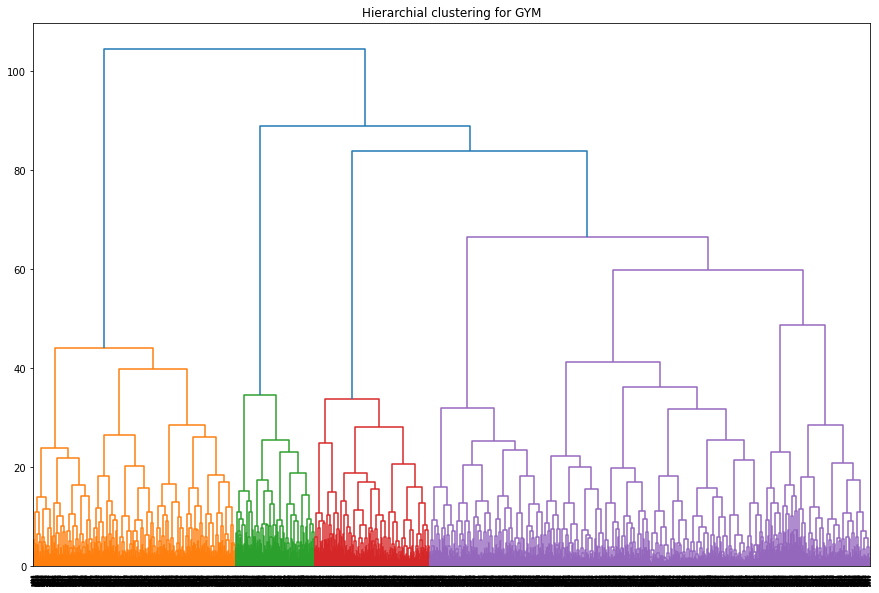

In [19]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

По Дендрограмме видно, что можно выделить 4, 5 или 6 больших кластеров клиентов (Визуально я бы выбрал 6 кластеров)

## Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

Договоримся за число кластеров принять n=5, чтобы наши результаты можно было сравнивать с результатами остальных студентов:

In [20]:
km = KMeans(n_clusters = 5, random_state=0) # задаём число кластеров, равное 5
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров
labels

array([1, 0, 3, ..., 0, 0, 1])

Теперь добавим столбец с номерами кластеров в первоначальный датафрейм:

In [21]:
data['cluster_km'] = labels
data

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster_km
0,True,True,True,True,False,6,True,29,14.227470,5,3,0.020398,0.000000,False,1
1,False,True,False,False,True,12,True,31,113.202938,12,7,1.922936,1.910244,False,0
2,False,True,True,False,True,1,False,28,129.448479,1,2,1.859098,1.736502,False,3
3,False,True,True,True,True,12,True,33,62.669863,12,2,3.205633,3.357215,False,0
4,True,True,True,True,True,1,False,26,198.362265,1,3,1.113884,1.120078,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,True,True,True,False,True,12,False,33,2.406023,12,8,2.284497,2.349070,False,0
3996,False,True,False,False,True,1,True,29,68.883764,1,1,1.277168,0.292859,True,3
3997,True,True,True,True,True,12,False,28,78.250542,11,2,2.786146,2.831439,False,0
3998,False,True,True,True,True,6,False,32,61.912657,5,3,1.630108,1.596237,False,0


Посмотрим сколько клиентов в кластерах:

In [22]:
data.groupby(['cluster_km'])['gender'].count()

cluster_km
0    1010
1     385
2     505
3    1262
4     838
Name: gender, dtype: int64

Посчитаем метрику силуэта для нашей кластеризации:

In [23]:
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette_score: 0.14


- Значение метрики силуэта принимает значения от -1 до 1. Чем ближе к 1, тем качественнее кластеризация.


- Судя по Silhouette_score=0.14, - кластеризация прошла плохо.

## Посмотрим на средние значения признаков для кластеров

In [24]:
display(data.groupby('cluster_km').agg('mean').T)

cluster_km,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


Для наглядности выведем общие средние по признакам:

In [25]:
data.drop(['cluster_km', 'churn'], axis=1).mean()

gender                                 0.510250
near_location                          0.845250
partner                                0.486750
promo_friends                          0.308500
phone                                  0.903500
contract_period                        4.681250
group_visits                           0.412250
age                                   29.184250
avg_additional_charges_total         146.943728
month_to_end_contract                  4.322750
lifetime                               3.724750
avg_class_frequency_total              1.879020
avg_class_frequency_current_month      1.767052
dtype: float64



- Кластер 0:
- Cамый надёжный кластер, всего 2,7% оттока
- "partner" - высокая доля 78.3%,
- "promo_friends" - много по сравнению с другими кластерами (57.5% против 8-30,6%) "contract_period" - большой 11 месяцев (12 если в реале) "month_to_end_contract" - также большой - 10 месяцев
Это те клиенты, кто купил абонемент на 12мес по Промо или Партнер и проходил совсем не много 1-2 месяца.
    

- Кластер 1:
- самый средний кластер -26,7% оттока    
- "phone" = 0
- Как ни странно, но это те кто не оставил телефон.
    

- Кластер 2:
- второй снизу по количеству оттока кластер - 44,3%    
"near_location" = 0
"promo_friends" = 8%
"group_visits" = 21,6%
Это те клиенты, кто живет не близко и в основном пришел без промо-акции, мало склонен к групповым занятиям
    

- Кластер 3:
- лидеры по оттоку - 51,4%.    
- "avg_class_frequency_total" = 1,25
- "avg_class_frequency_current_month" = 1,01
- Те клиенты, которые мало ходят примерно 1 раз в неделю.
    

- Кластер 4:
- Кластер с оттоком в 6,8%
- "avg_class_frequency_total" = 2,85
- "avg_class_frequency_current_month" = 2,85
- А эти противоположность кластеру 3 - любители фитнеса, ходят примерно 3 раз в неделю (закоренелые "фитнесеры")



## Построим распределения признаков для кластеров.

In [26]:
# Функция для построения графика распредления и ящика с усами для непрерывных признаков по кластерам.
# Принимает на вход датафрейм, название признака и заголовок для графиков.
def cluster_cntns_feature_plots(data, feature, title):
    fig, ax = plt.subplots(figsize = (12, 4))

    # Создаём список кластеров:
    cluster_names = data['cluster_km'].unique()  # [0, 1, 2, 3, 4]
    cluster_names = np.sort(cluster_names)
    
    # Создаём список датафреймов по кластерам:
    clusters = [data.loc[data['cluster_km'] == i] for i in cluster_names]

    # Строим распределение признака по каждому кластеру:
    for cluster in clusters:
        try:
            sns.distplot(cluster[feature], label = cluster['cluster_km'].unique(), hist=False, ax = plt.subplot(1, 2, 1))
        except RuntimeError as re:
            if str(re).startswith("Selected KDE bandwidth is 0. Cannot estiamte density."):
                sns.distplot(cluster[feature], label = cluster['cluster_km'].unique(), hist=False, kde_kws={'bw': 0.1}, ax = plt.subplot(1, 2, 1))
            else:
                raise re   
        plt.xlabel('')
        plt.ylabel('')
        plt.legend()

    sns.boxplot(y = data[feature], x = data['cluster_km'], ax = plt.subplot(1, 2, 2)) 
    plt.xlabel('')
    plt.ylabel('')

    fig.suptitle(title + ' (' + feature + ') по кластерам')
    plt.show()

In [27]:
# Функция для построения гистограммы и ящика с усами для дискретных признаков по кластерам.
# Принимает на вход датафрейм, название признака и заголовок для графиков.
def cluster_dscrt_feature_plots(data, feature, title):  
    fig, ax = plt.subplots(figsize = (12, 4))
    
    sns.countplot(x='cluster_km', hue=feature, data=data, ax=plt.subplot(1, 2, 1))
    plt.ylabel('')
    plt.xlabel('')
    plt.legend()

    gr = data.groupby([feature, 'cluster_km']).agg(count=('age', 'count')).reset_index()
    sns.boxplot(x='cluster_km', y='count', data=gr, ax = plt.subplot(1, 2, 2)) 
    plt.xlabel('')
    plt.ylabel('')

    fig.suptitle(title + ' (' + feature + ') по кластерам')
    plt.show()

Посмотрим на распределения числовых признаков по кластерам:

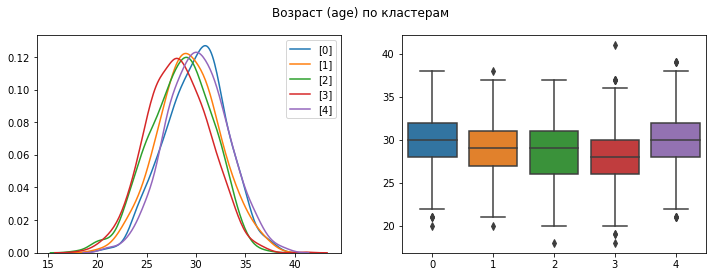

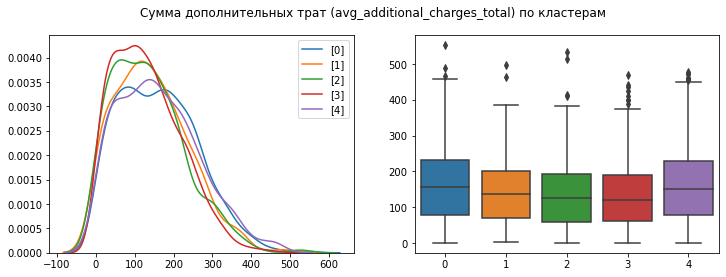

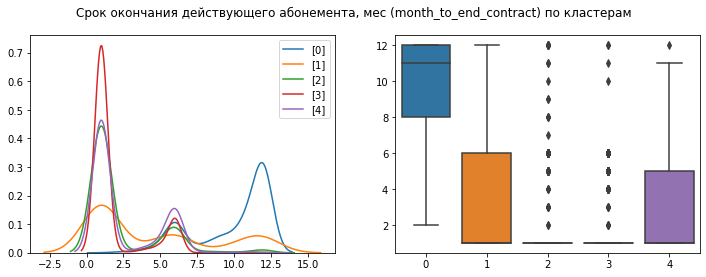

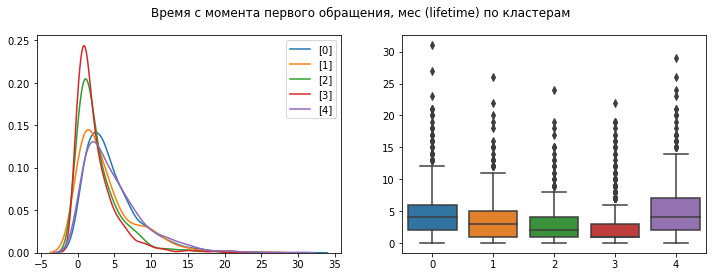

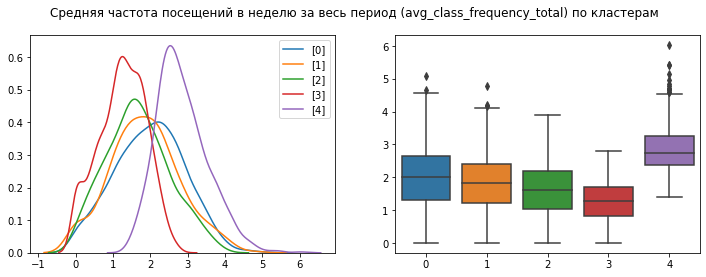

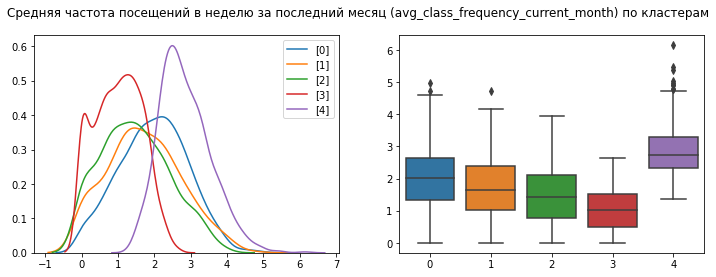

In [28]:
for index, row in cnt_features.iterrows():
    cluster_cntns_feature_plots(data, row[0], row[1])

В самых надёжных кластерах (№0 и №4) оказалось больше клиентов старшего возраста, чем в остальных. Самый рискованный кластер (№3), напротив, смещён по оси возраста влево.
В целом, практически все распределения упорядочены по оси x по степени их склонности к оттоку - левее и чаcто выше всех кластер №3, затем 2-й и 1-й.

**Рассмотрим гистограммы дискретных признаков:**

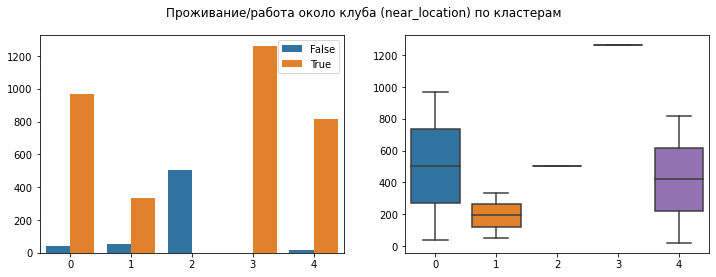

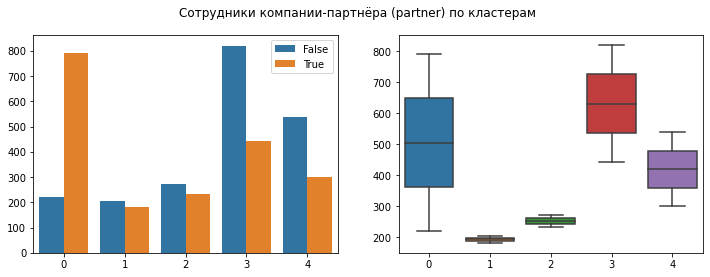

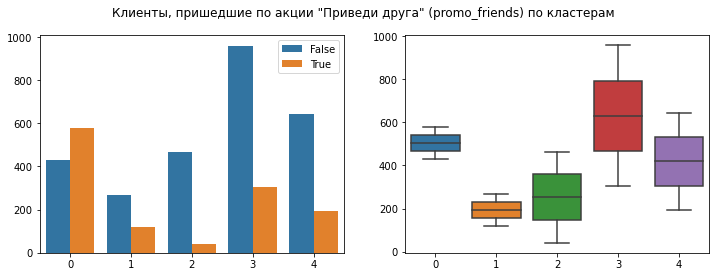

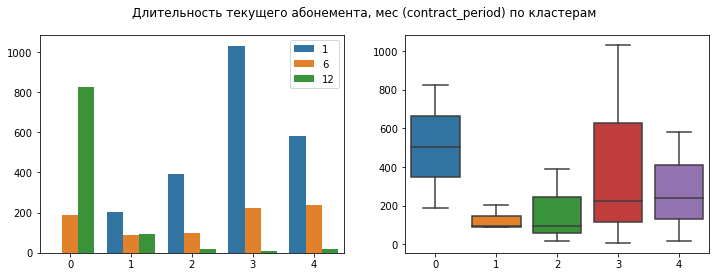

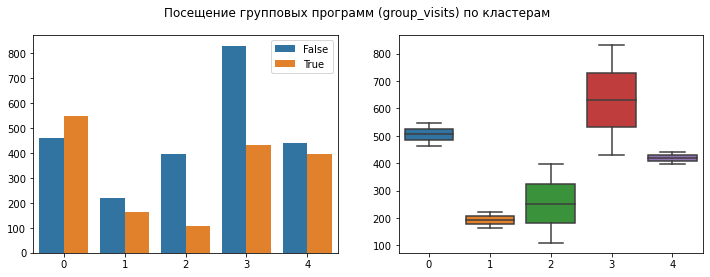

In [29]:
dscrt_features = dscrt_features[~dscrt_features['feature'].isin(['gender', 'phone'])]

for index, row in dscrt_features.iterrows():
    cluster_dscrt_feature_plots(data, row[0], row[1])

- В самом надёжном кластере (№0) оказалась львиная доля клиентов с абонементом на 12 месяцев. В самый рискованный (№3), напротив, попало больше клиентов с абонементом на 1 месяц, чем в остальные кластеры.
- Любопытно, что в 3-м кластере (самом рискованном) находятся клиенты, живущие/работающие неподалёку от клуба.

# Шаг 5. Сформулируем выводы и сделаем базовые рекомендации по работе с клиентами¶

После проведения анализа и подготовки данных нам удалось разработать алгоритм для предсказывания оттока клиентов на уровне следующего месяца с полнотой 86% (доля оттока, которую удаётся обнаружить).


Выявлены основные признаки, влияющие на отток (обратно пропорционально):


- жизненный путь клиента lifetime
- средняя частоста посещений клуба за последний месяц avg_class_frequency_current_month
- возраст age
- срок действующего абонемента contract_period
- количество месяцев до истечения абонемента month_to_end_contract

**Сформированы типичные портреты клиентов:**

In [30]:
display(data.groupby('cluster_km').agg('mean').T)

cluster_km,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


 - Наиболее яркие особенности самого рискованного с точки зрения оттока Кластера №3:
- проживание/работа неподалёку от клуба
- непродолжительный действующий абонемент (в среднем на 1.95 мес)
- сравнительно молодой возраст
- сравнительно низкие дополнительные траты
- небольшой срок окончания абонемента (в среднем 1.85 мес)
- низкие показатели посещения клуба в целом и за последний месяц в частности
- Данный кластер клиентов в целом имеет минимальные показатели по большинству признаков.


- Противоположный, наиболее надёжный Кластер №0, имеет сравнительно высокие средние значения по всем призникам, но особенно выделяется продолжительным абонементом (в среднем 10.8 мес) и количеством месяцев до его окончания (9.9)



В целом, практически все распределения признаков упорядочены по степени их склонности к оттоку - чем меньше значение параметра, тем вероятнее отток.


Следовательно, борьба с оттоком должна быть направлена на максимизацию всех возможных параметров.


Например: 1) Клиентов, попавших в Кластер №3, нужно постараться перевести в Кластер №4 (надёжный и наиболее близкий):

In [31]:
cluster_diff = data.drop('churn', axis = 1).groupby('cluster_km').agg('mean').T[[3, 4]]
cluster_diff['difference_prc'] = round((cluster_diff[4] - cluster_diff[3])/cluster_diff[4] * 100, 1)
display(cluster_diff.sort_values('difference_prc', ascending = False))

cluster_km,3,4,difference_prc
avg_class_frequency_current_month,1.012983,2.850161,64.5
avg_class_frequency_total,1.247634,2.852002,56.3
lifetime,2.440571,4.898568,50.2
group_visits,0.341521,0.473747,27.9
contract_period,1.948494,2.669451,27.0
month_to_end_contract,1.856577,2.459427,24.5
avg_additional_charges_total,131.622204,161.657905,18.6
gender,0.485737,0.559666,13.2
age,28.167987,30.125298,6.5
partner,0.350238,0.356802,1.8


Основное различие между ними, на которое мы можем повлиять - частота посещений. Нужно предлагать данной категории клиентов бонусы за регулярность и частоту - возможно, сверх-скидки на продолжительные абонементы / занятие с тренером, как награда за регулярное посещение. Нужно активно предлагать данным клиентам групповые программы, возможно, предлагать бесплатное посещение коммерческих классов (если такие вообще есть).

2) Клиентов, попавших в Кластер №2, так же нужно стремиться перевести в Кластер №1 за счёт стимуляции регулярного посещения.

3) Кластер №1 (26% оттока) отличается от самого надёжного Кластера №0 в основном продолжительностью абонемента:

In [32]:
cluster_diff = data.drop('churn', axis = 1).groupby('cluster_km').agg('mean').T[[1, 2]]
cluster_diff['difference_prc'] = round((cluster_diff[1] - cluster_diff[2])/cluster_diff[1] * 100, 1)
display(cluster_diff.sort_values('difference_prc', ascending = False))

cluster_km,1,2,difference_prc
near_location,0.862338,0.000000,100.0
promo_friends,0.306494,0.079208,74.2
contract_period,4.787013,2.352475,50.9
month_to_end_contract,4.475325,2.198020,50.9
group_visits,0.425974,0.215842,49.3
lifetime,3.924675,2.809901,28.4
avg_class_frequency_current_month,1.716369,1.477324,13.9
avg_class_frequency_total,1.847220,1.660461,10.1
avg_additional_charges_total,143.957664,135.457501,5.9
gender,0.522078,0.495050,5.2


Значит, данной категории пользователей стоит предлагать льготные условия по продлению абонемента, причём, стремиться продлить договор на максимально возможный срок и активнее продвигать акцию 'приведи друга'